In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
N = 100 # Number of samples
L = 1000 # Length for each sample/ values for each sine wave
T = 20 # Time period

In [3]:
x = np.empty((N,L), dtype=np.float32) # Creating samples
x

array([[0.0000000e+00, 0.0000000e+00, 3.5464752e-37, ..., 6.8905651e+22,
        1.7236775e+25, 7.2064755e+31],
       [5.4213887e-11, 1.3563128e-19, 1.3563156e-19, ..., 2.8858341e-41,
        9.5917871e-39, 2.0111974e-38],
       [1.8285003e+25, 2.3611832e+21, 2.8025969e-45, ..., 1.1692423e-19,
        1.3563156e-19, 1.3563156e-19],
       ...,
       [3.5733111e-43, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        3.5733111e-43, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [4]:
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N,1) 
# np.array(range(L)) - Will allot 0 to 999 in ascending values in all N rows
# Here we use T as the phase shifter
# np.random.randint(-4*T, 4*T, N).reshape(N,1) - 
# This will add and subtract 1 random integer at each row to shift the ascending numbers
# This will give values between 0 to 999 and shift them a little bit at each row

x

array([[ -61.,  -60.,  -59., ...,  936.,  937.,  938.],
       [  32.,   33.,   34., ..., 1029., 1030., 1031.],
       [  74.,   75.,   76., ..., 1071., 1072., 1073.],
       ...,
       [ -23.,  -22.,  -21., ...,  974.,  975.,  976.],
       [ -23.,  -22.,  -21., ...,  974.,  975.,  976.],
       [ -59.,  -58.,  -57., ...,  938.,  939.,  940.]], dtype=float32)

In [5]:
y = np.sin(x/1.0/T).astype(np.float32) # Will result in N (100) phase shifted sine waves

In [6]:
print(x.shape) # (N, L)
print(y.shape) # (N, L)

(100, 1000)
(100, 1000)


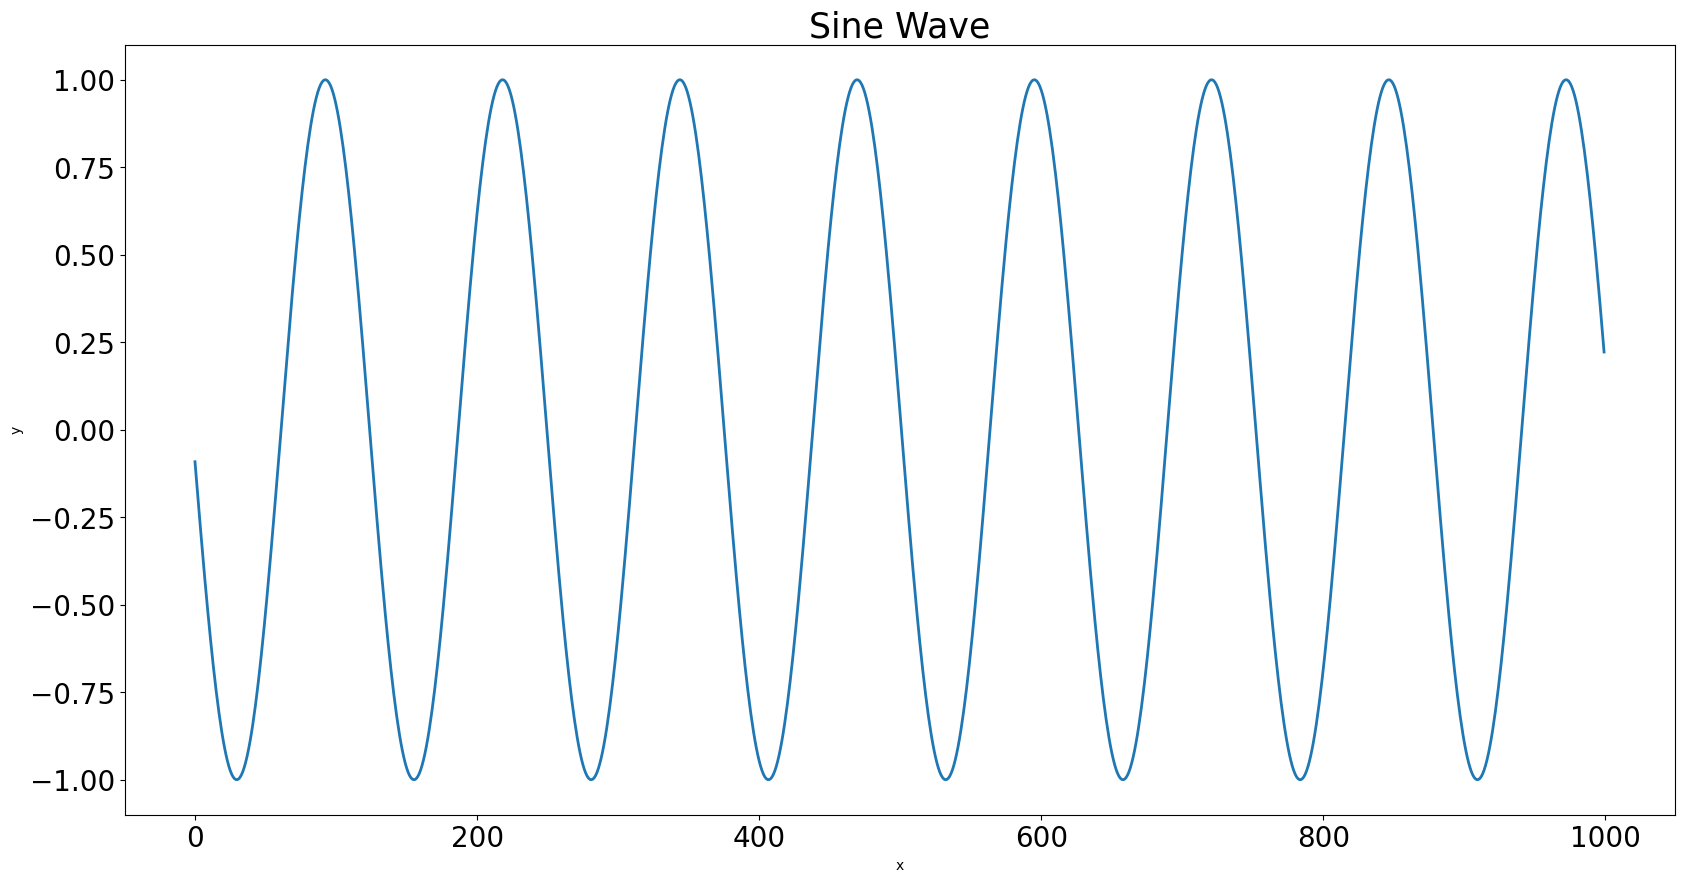

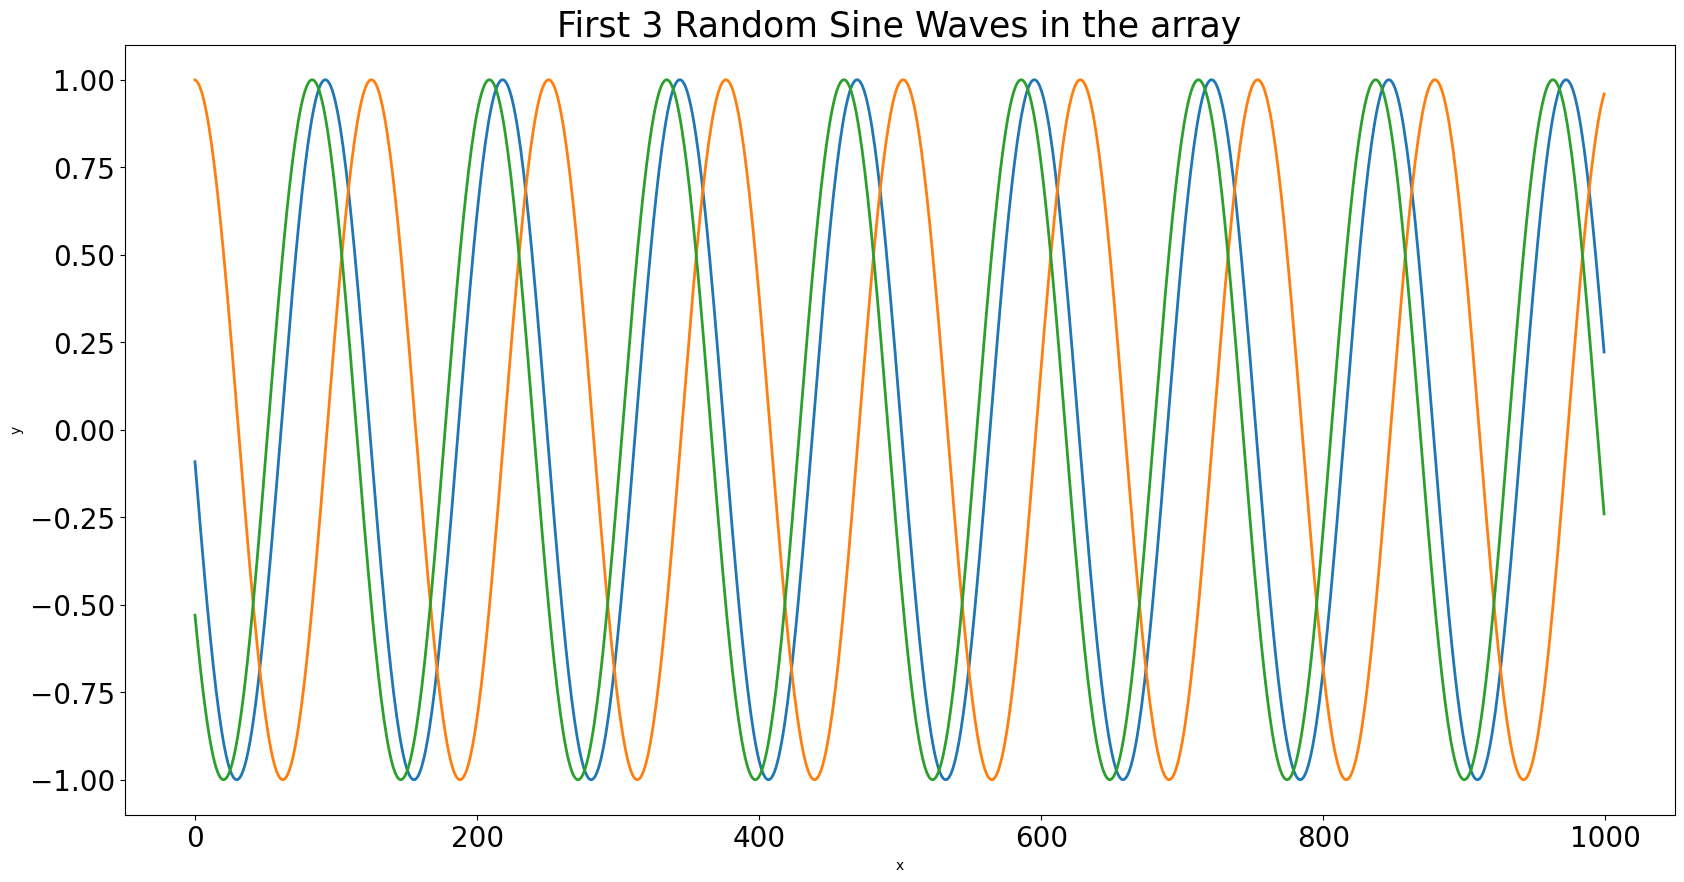

In [7]:
plt.figure(1, figsize=(20,10))
plt.title("Sine Wave", fontsize = 25)
plt.xlabel('x')
plt.ylabel('y')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.plot(np.arange(x.shape[1]), y[0,:], linewidth = 2.0)
plt.show()

plt.figure(2, figsize=(20,10))
plt.title("First 3 Random Sine Waves in the array", fontsize = 25)
plt.xlabel('x')
plt.ylabel('y')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.plot(np.arange(x.shape[1]), y[0,:], linewidth = 2.0)
plt.plot(np.arange(x.shape[1]), y[1,:], linewidth = 2.0) # Randomly shifted
plt.plot(np.arange(x.shape[1]), y[2,:], linewidth = 2.0) # Randomly shifted
plt.show()

# **AIM**: Predict NEXT 1000 samples using LSTMs

## LSTM Cell equations (`nn.LSTMCell`)
$$\tilde c^{<t>} = \tanh(W_c[h^{<t-1>}, x^{<t>}]+b_c)$$
$$\Gamma_u = \sigma(W_u[h^{<t-1>}, x^{<t>}]+b_u)$$
$$\Gamma_f = \sigma(W_f[h^{<t-1>}, x^{<t>}]+b_f)$$
$$\Gamma_o = \sigma(W_o[h^{<t-1>}, x^{<t>}]+b_o)$$
$$c^{<t>} = \Gamma_u * \tilde c^{<t>} + \Gamma_f * c^{<t-1>}$$
$$h^{<t>} = \Gamma_o * \tanh(c^{<t>})$$

WHERE -
- $t$ = Time-step number
- $h^{<t>}$ = Current Hidden State
- $h^{<t-1>}$ = Previous Hidden State
- $c^{<t>}$ = Current Cell State
- $c^{<t-1>}$ = Previous Cell State

- **$\tilde c^{<t>}$: Candidate vector** of $t^{th}$ LSTM Block
- $\Gamma_u$: **Update Gate**
    - Ranges from 0 to 1
    - Decides how much of the candidate will be UPDATED to the **current cell state $c^{t}$**
- $\Gamma_f$: **Forget Gate**
    - Ranges from 0 to 1
    - Decides how much of the previous cell state will be FORGOTTEN from the **current cell state $c^{t}$**
- $\Gamma_o$: **Output Gate**
    - Ranges from 0 to 1
    - Decides how much of the current cell state will play a role in the calculation of the **current hidden state $h^{t}$**

In [8]:
class LSTMPredictor(nn.Module):
    def __init__(self, hidden_size = 100) -> None:
        super(LSTMPredictor, self).__init__()

        self.hidden_size = hidden_size

        # lstm1, lstm2, linear

        # LSTMCell: Only one cell of LSTM Equations
        self.lstm1 = nn.LSTMCell(1, self.hidden_size) # 1: We go with sine values one by one
        self.lstm2 = nn.LSTMCell(self.hidden_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, 1)

    def forward(self, x, future = 0):
        # Future is by default None
        # Setting the future as 9 for example makes the model predict the next 90 future values

        #x --> Complete input sine wave of 1000 samples
        outputs = []
        n_samples = x.size(0)

        h_t1 = torch.zeros(n_samples, self.hidden_size, dtype = torch.float32) # First Cell
        c_t1 = torch.zeros(n_samples, self.hidden_size, dtype = torch.float32) # First Cell
        h_t2 = torch.zeros(n_samples, self.hidden_size, dtype = torch.float32) # Second Cell
        c_t2 = torch.zeros(n_samples, self.hidden_size, dtype = torch.float32) # Second Cell

        for input_t in x.split(1, dim=1):
            # x: (N, L)
            # input_t: (N, 1)
            h_t1, c_t1 = self.lstm1(input_t, (h_t1, c_t1)) # h_t1 = vector of dimension hidden_size
            h_t2, c_t2 = self.lstm2(h_t1, (h_t2, c_t2)) # h_t2 = vector of dimension hidden_size
            output = self.linear(h_t2) # output at each cell = 1 single value
            outputs.append(output) # Will finally obtain output of every block as a list `outputs`
        
        for i in range(future): # Will run only if future > 0
            with torch.no_grad():
                h_t1, c_t1 = self.lstm1(output, (h_t1, c_t1)) # We input the output of the previous lstm block
                h_t2, c_t2 = self.lstm2(h_t1, (h_t2, c_t2))
                output = self.linear(h_t2)
                outputs.append(output)

        outputs = torch.cat(outputs, 1)
        return outputs
    
    def generate_sequence(self, inputs, n = 1000):
        outputs = []
        output = inputs
        h_t1 = torch.zeros(1, self.hidden_size, dtype = torch.float32) # First Cell
        c_t1 = torch.zeros(1, self.hidden_size, dtype = torch.float32) # First Cell
        h_t2 = torch.zeros(1, self.hidden_size, dtype = torch.float32) # Second Cell
        c_t2 = torch.zeros(1, self.hidden_size, dtype = torch.float32) # Second Cell
        for i in range(n):
            with torch.no_grad():
                h_t1, c_t1 = self.lstm1(output, (h_t1, c_t1)) # We input the output of the previous lstm block
                h_t2, c_t2 = self.lstm2(h_t1, (h_t2, c_t2))
                output = self.linear(h_t2)
                outputs.append(output)
        outputs = torch.cat(outputs, 1)
        return outputs

In [9]:
n_test = 2

# TRAIN DATA
train_input = torch.from_numpy(y[n_test:,:-1]) # Inputs for the 996 sine waves used for training [shape = (996, 999)]
train_target = torch.from_numpy(y[n_test:,1:]) # For comparing with the predicted outputs [shape = (996, 999)]

# TEST DATA
test_input = torch.from_numpy(y[0:n_test,:-1]) # The first n_test sine waves for testing [shape = (n_test, 999)]
test_target = torch.from_numpy(y[0:n_test:,1:]) # [shape = (n_test, 999)]

In [10]:
lstm = LSTMPredictor(hidden_size = 100)
criterion = nn.MSELoss() # Euclidean distance minimisation of the train_input sine wave to the train_target sine wave

#### Optimizer used: **Limited-Memory Broyden-Fletcher-Goldfarb-Shanno Algorithm (LBFGS)**
It is an optimizion algorithm which *approximates* Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm using a limited amount of computer memory

- Can work on the whole data
- Needs a *function* as an input

In [11]:
optimizer = torch.optim.LBFGS(lstm.parameters(), lr=9e-1)

In [12]:
n_steps = 10

In [13]:
test_input.shape

torch.Size([2, 999])

Step 1
Train Loss: 0.5068293809890747
Train Loss: 0.5047709345817566
Train Loss: 0.3862369954586029
Train Loss: 0.17117643356323242
Train Loss: 3.4469237327575684
Train Loss: 0.03709622472524643
Train Loss: 0.027042560279369354
Train Loss: 0.025444140657782555
Train Loss: 0.025143466889858246
Train Loss: 0.024274563416838646
Train Loss: 0.022571837529540062
Train Loss: 0.018865300342440605
Train Loss: 0.012756401672959328
Train Loss: 0.005024408921599388
Train Loss: 0.0029540087562054396
Train Loss: 0.0021815274376422167
Train Loss: 0.001882993383333087
Train Loss: 0.0013730240752920508
Train Loss: 0.0011138403788208961
Train Loss: 0.0010286452015861869
Test Loss: 0.0009346925653517246


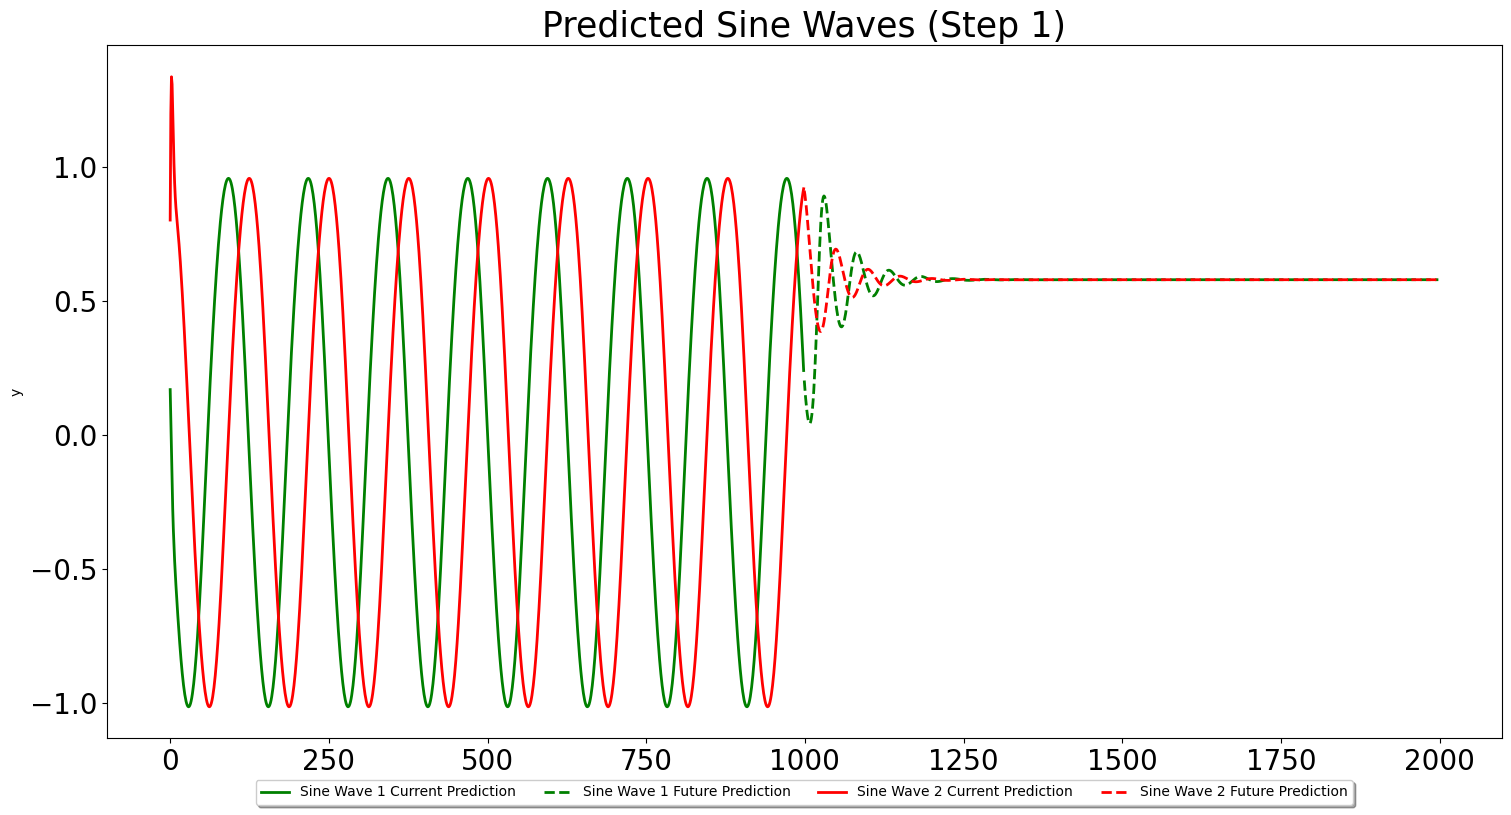

Step 2
Train Loss: 0.0009489780059084296
Train Loss: 0.0007356808637268841
Train Loss: 0.0005278868484310806
Train Loss: 0.00040942695341072977
Train Loss: 0.00037775564123876393
Train Loss: 0.0003707720316015184
Train Loss: 0.00036575092235580087
Train Loss: 0.0003535053401719779
Train Loss: 0.00032842016662470996
Train Loss: 0.0002980587596539408
Train Loss: 0.00027062761364504695
Train Loss: 0.00021944043692201376
Train Loss: 0.00018883784650824964
Train Loss: 0.00017791183199733496
Train Loss: 0.00020364283409435302
Train Loss: 0.00016958893684204668
Train Loss: 0.0001691167854005471
Train Loss: 0.0001687681651674211
Train Loss: 0.0001685652823653072
Train Loss: 0.0001673412771197036
Test Loss: 0.00019936032185796648


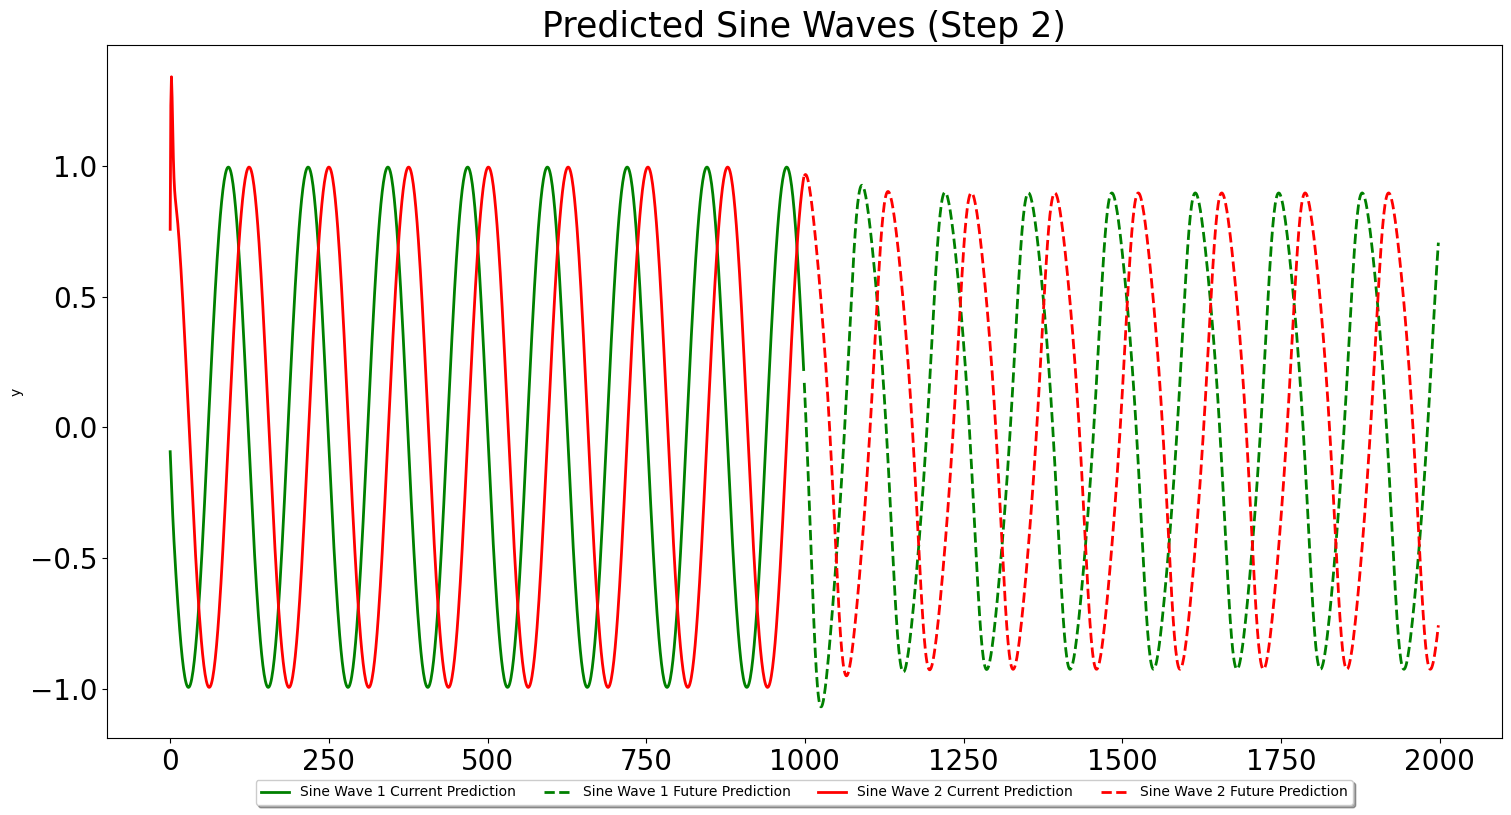

Step 3
Train Loss: 0.00015525160415563732
Train Loss: 0.00014176878903526813
Train Loss: 0.00013701747229788452
Train Loss: 0.00013035297160968184
Train Loss: 0.00012591636914294213
Train Loss: 0.00012311741011217237
Train Loss: 0.00012218052870593965
Train Loss: 0.00012104447523597628
Train Loss: 0.00012051571684423834
Train Loss: 0.00012016187974950299
Train Loss: 0.00012005173630313948
Train Loss: 0.0001199705948238261
Train Loss: 0.00011987597099505365
Train Loss: 0.00011976784298894927
Train Loss: 0.00011954459478147328
Train Loss: 0.00011903299309778959
Train Loss: 0.00011786196409957483
Train Loss: 0.00011459155211923644
Train Loss: 0.00010104077227879316
Train Loss: 0.00153775152284652
Test Loss: 0.00011720939073711634


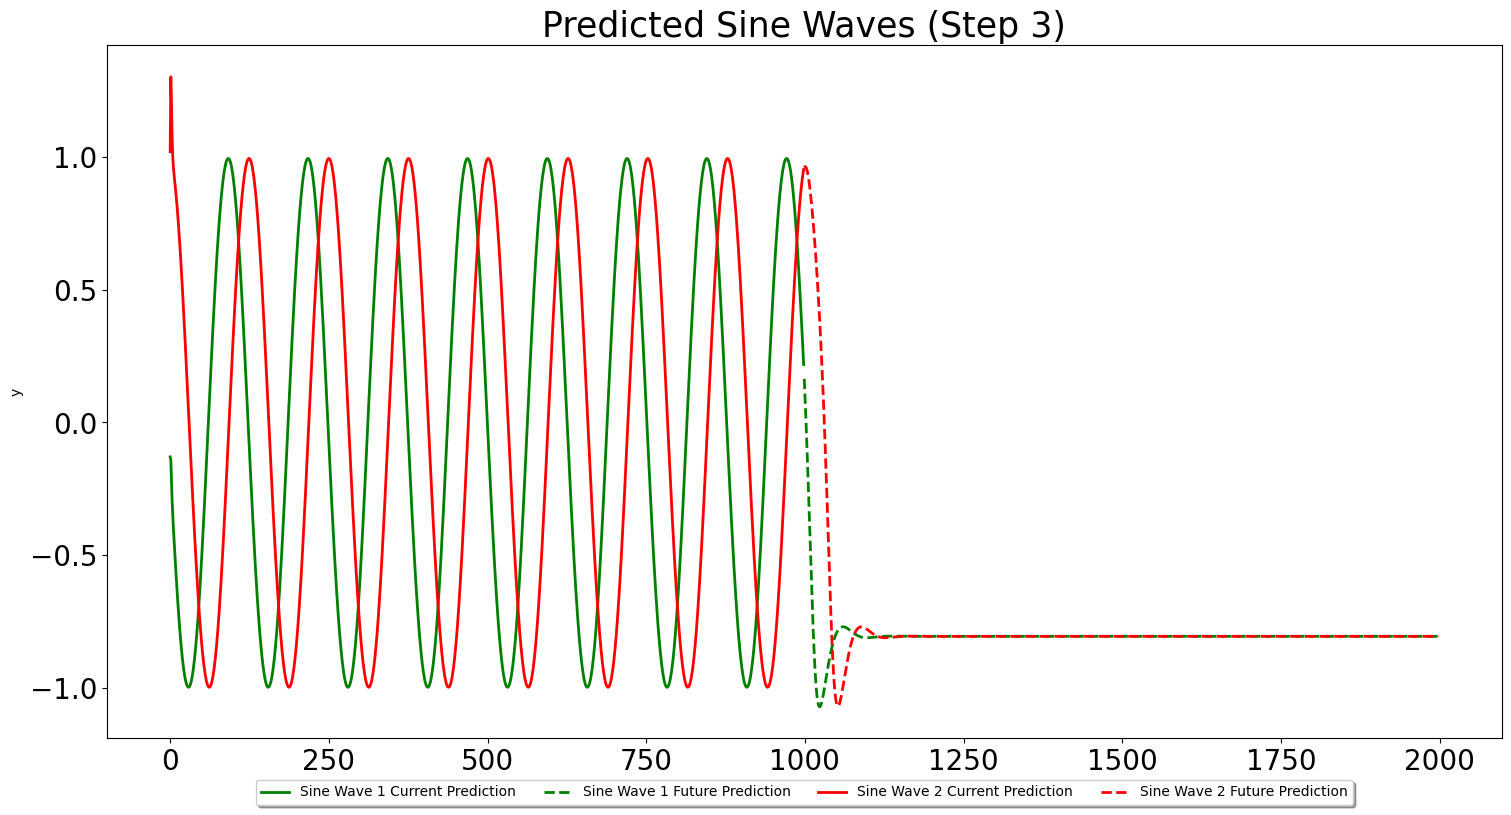

Step 4
Train Loss: 0.00010157525684917346
Train Loss: 0.0002590800868347287
Train Loss: 0.00013229988690000027
Train Loss: 0.0006378353573381901
Train Loss: 9.795486403163522e-05
Train Loss: 9.217631304636598e-05
Train Loss: 8.648991206428036e-05
Train Loss: 7.57210873416625e-05
Train Loss: 7.040344644337893e-05
Train Loss: 6.661113729933277e-05
Train Loss: 5.8981695474358276e-05
Train Loss: 5.676804721588269e-05
Train Loss: 5.5658540077274665e-05
Train Loss: 5.464867354021408e-05
Train Loss: 5.409870209405199e-05
Train Loss: 5.294659422361292e-05
Train Loss: 5.243398845777847e-05
Train Loss: 5.2297680667834356e-05
Train Loss: 5.211972165852785e-05
Train Loss: 5.200983287068084e-05
Test Loss: 5.1004615670535713e-05


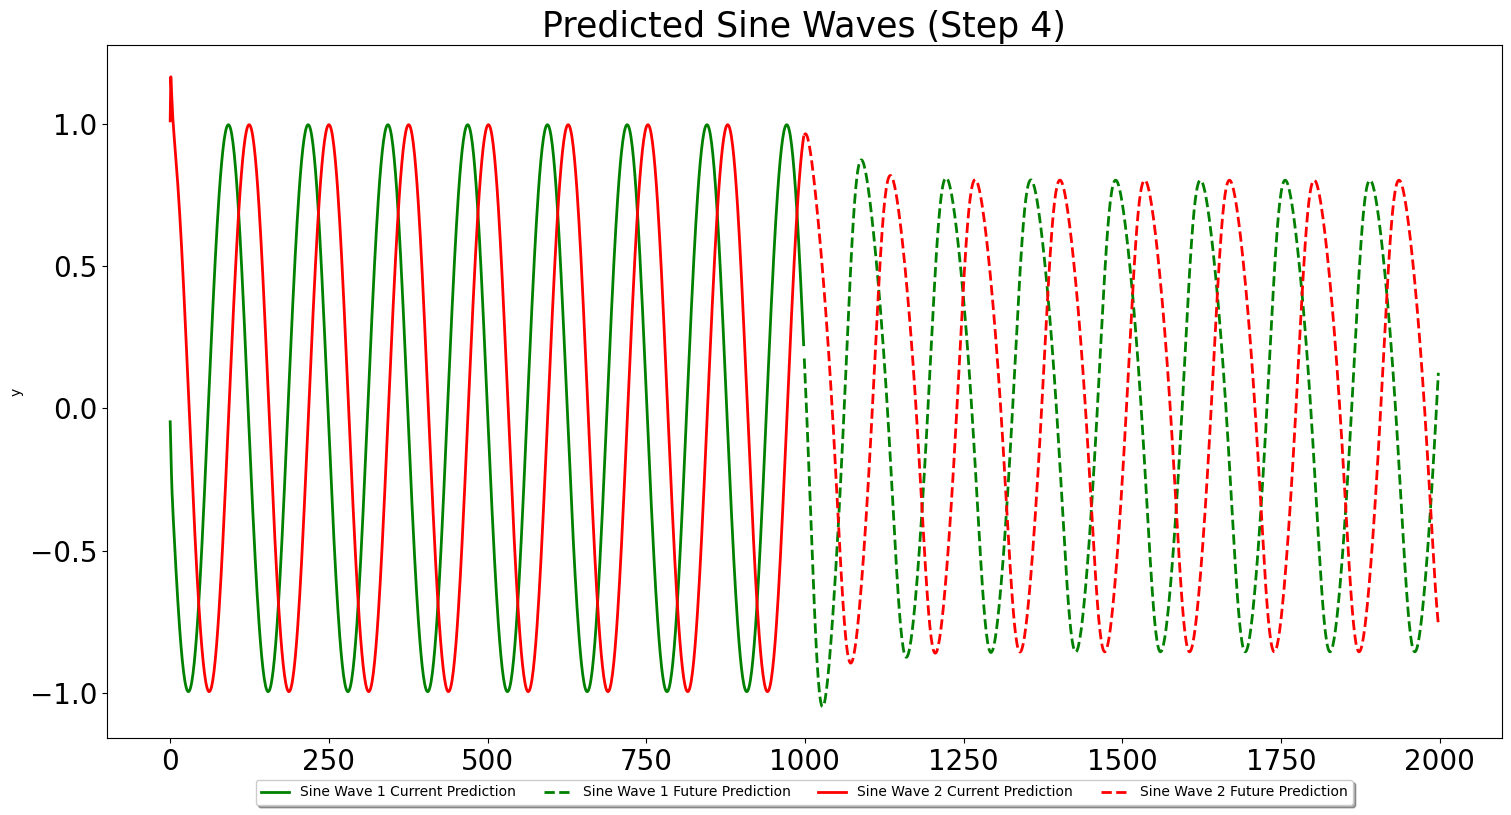

Step 5
Train Loss: 5.188525392441079e-05
Train Loss: 5.175924161449075e-05
Train Loss: 5.1554357924032956e-05
Train Loss: 5.1262701163068414e-05
Train Loss: 5.102602153783664e-05
Train Loss: 5.07552940689493e-05
Train Loss: 5.047231024946086e-05
Train Loss: 5.006634455639869e-05
Train Loss: 4.9484417104395106e-05
Train Loss: 4.860011176788248e-05
Train Loss: 4.833415005123243e-05
Train Loss: 4.632096170098521e-05
Train Loss: 4.5705335651291534e-05
Train Loss: 4.5386979763861746e-05
Train Loss: 4.492875814321451e-05
Train Loss: 4.452237772056833e-05
Train Loss: 4.4401997001841664e-05
Train Loss: 4.416587034938857e-05
Train Loss: 4.330108276917599e-05
Train Loss: 4.215041917632334e-05
Test Loss: 4.881556014879607e-05


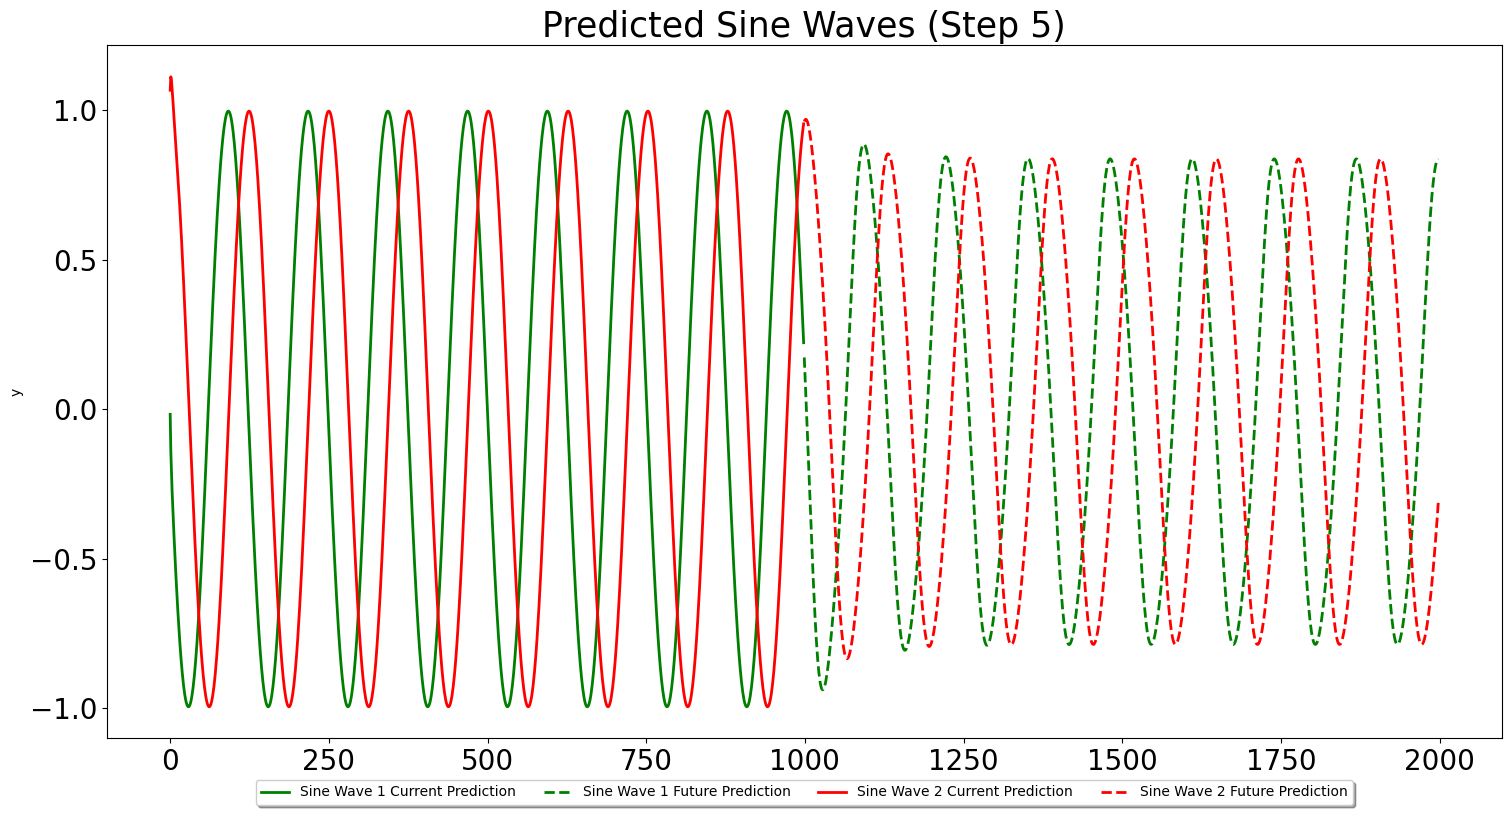

Step 6
Train Loss: 4.015535523649305e-05
Train Loss: 3.63214458047878e-05
Train Loss: 3.391721111256629e-05
Train Loss: 3.28911846736446e-05
Train Loss: 3.2527994335396215e-05
Train Loss: 3.212609590264037e-05
Train Loss: 3.18151869578287e-05
Train Loss: 3.16938130708877e-05
Train Loss: 3.165377347613685e-05
Train Loss: 3.160399501211941e-05
Train Loss: 3.1573581509292126e-05
Train Loss: 3.1555056921206415e-05
Train Loss: 3.1505722290603444e-05
Train Loss: 3.1344377930508927e-05
Train Loss: 3.107974771410227e-05
Train Loss: 3.075076892855577e-05
Train Loss: 3.04339610011084e-05
Train Loss: 3.014013600477483e-05
Train Loss: 2.9497421564883552e-05
Train Loss: 2.914385731855873e-05
Test Loss: 3.607272810768336e-05


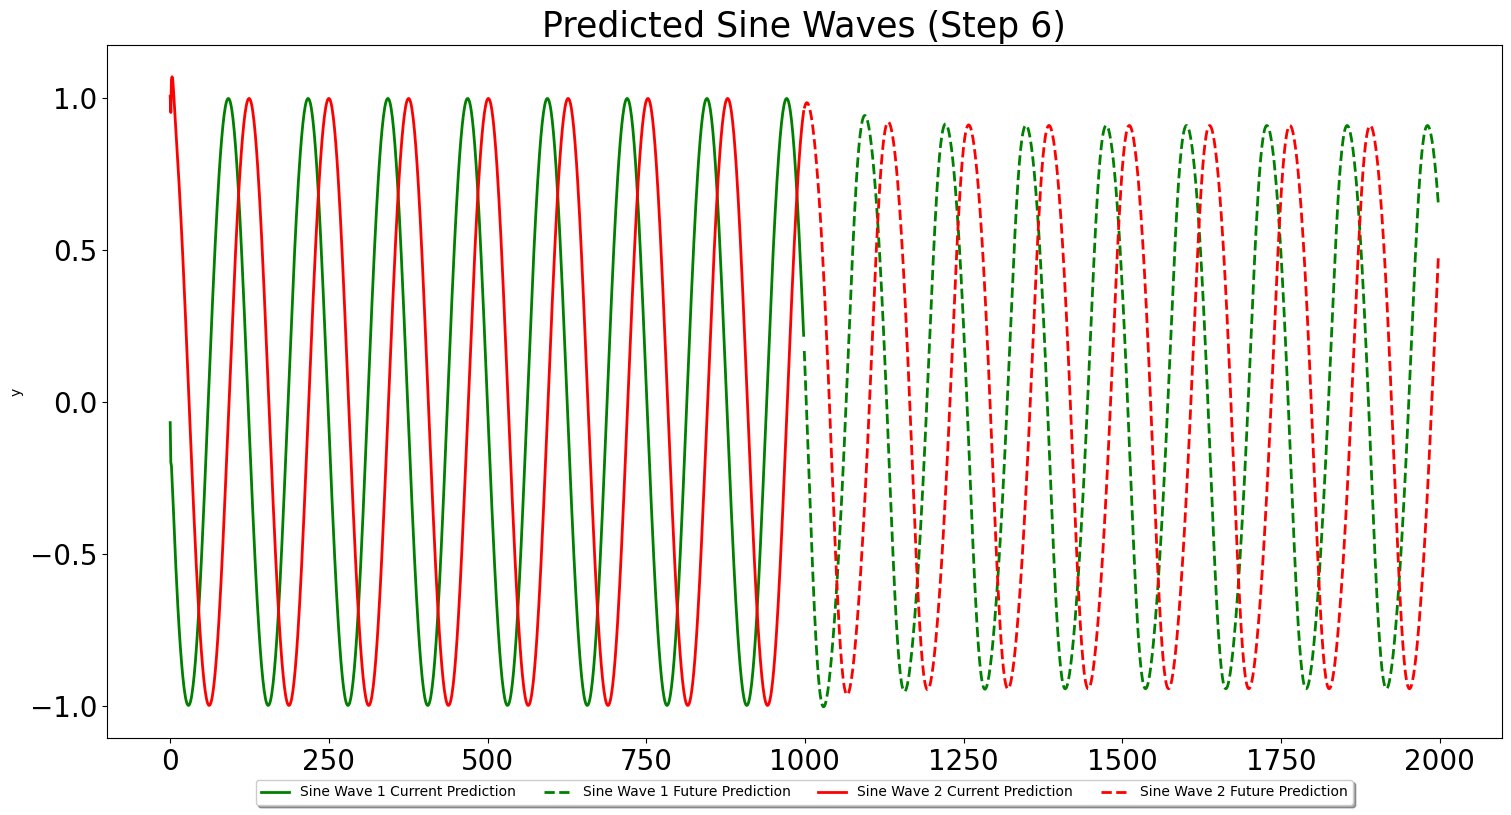

Step 7
Train Loss: 2.864404632418882e-05
Train Loss: 2.8178936190670356e-05
Train Loss: 2.707553176151123e-05
Train Loss: 2.563364978414029e-05
Train Loss: 2.530890742491465e-05
Train Loss: 2.5111865397775546e-05
Train Loss: 2.5034971258719452e-05
Train Loss: 2.5037315936060622e-05
Train Loss: 2.501874405425042e-05
Train Loss: 2.5015224309754558e-05
Train Loss: 2.499556285329163e-05
Train Loss: 2.4906670660129748e-05
Train Loss: 2.476458939781878e-05
Train Loss: 2.4461465727654286e-05
Train Loss: 2.421520730422344e-05
Train Loss: 2.405365557933692e-05
Train Loss: 2.3920110834296793e-05
Train Loss: 2.3693037292105146e-05
Train Loss: 2.338201375096105e-05
Train Loss: 2.2648851881967857e-05
Test Loss: 1.8973460100824013e-05


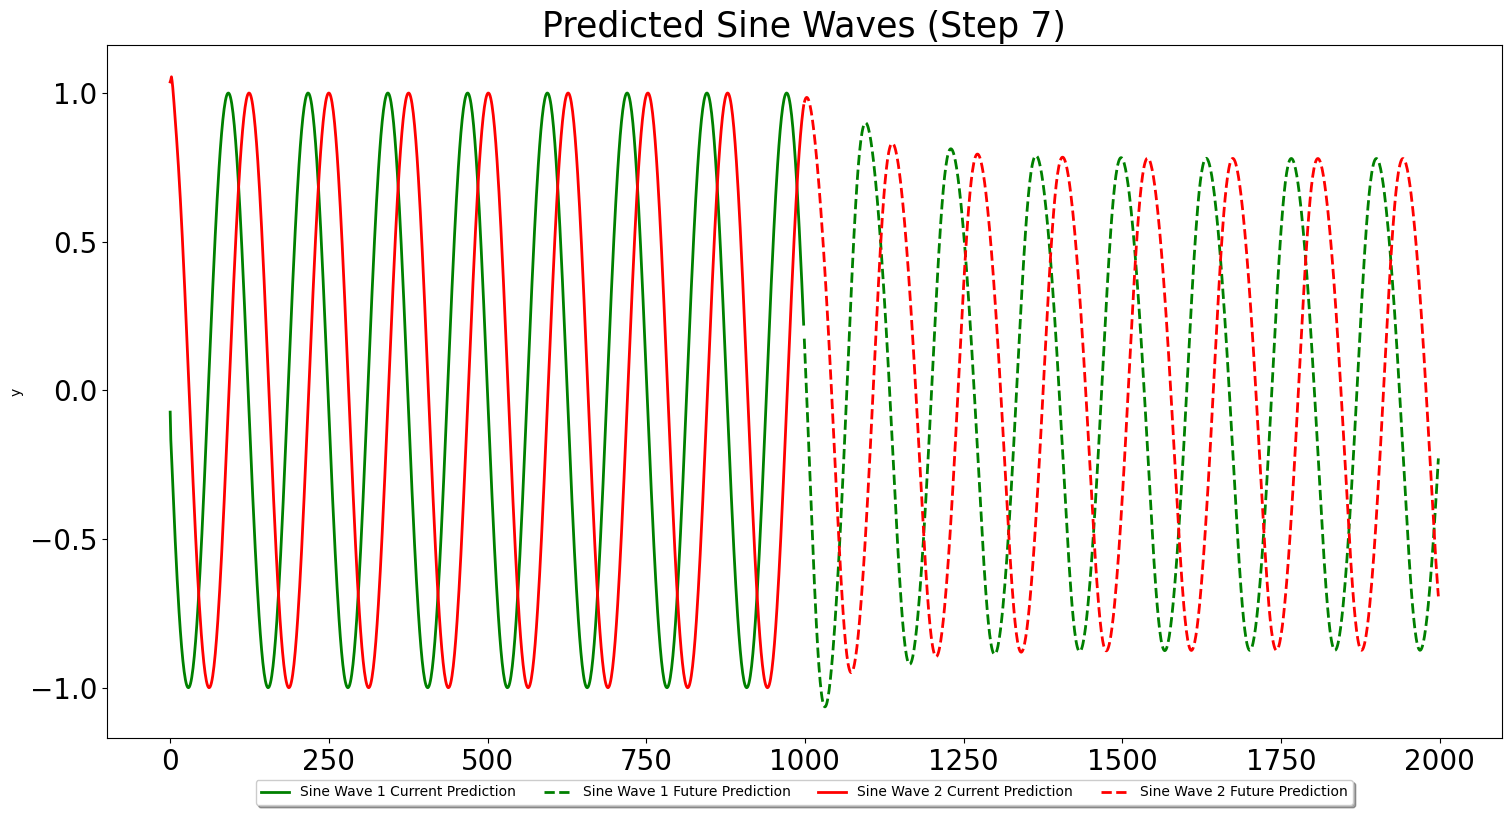

Step 8
Train Loss: 2.2305383026832715e-05
Train Loss: 2.2062373318476602e-05
Train Loss: 2.1959855075692758e-05
Train Loss: 2.1354626369429752e-05
Train Loss: 2.079197838611435e-05
Train Loss: 1.9569319192669354e-05
Train Loss: 1.8191460185335018e-05
Train Loss: 1.7035117707564496e-05
Train Loss: 2.207665966125205e-05
Train Loss: 1.8016235117102042e-05
Train Loss: 1.6150512237800285e-05
Train Loss: 1.591758700669743e-05
Train Loss: 1.5684199752286077e-05
Train Loss: 1.5372172128991224e-05
Train Loss: 1.5112852452148218e-05
Train Loss: 1.4805596038058866e-05
Train Loss: 1.4642366295447573e-05
Train Loss: 1.438016533938935e-05
Train Loss: 1.4269951861933805e-05
Train Loss: 1.4174211173667572e-05
Test Loss: 1.2798316674889065e-05


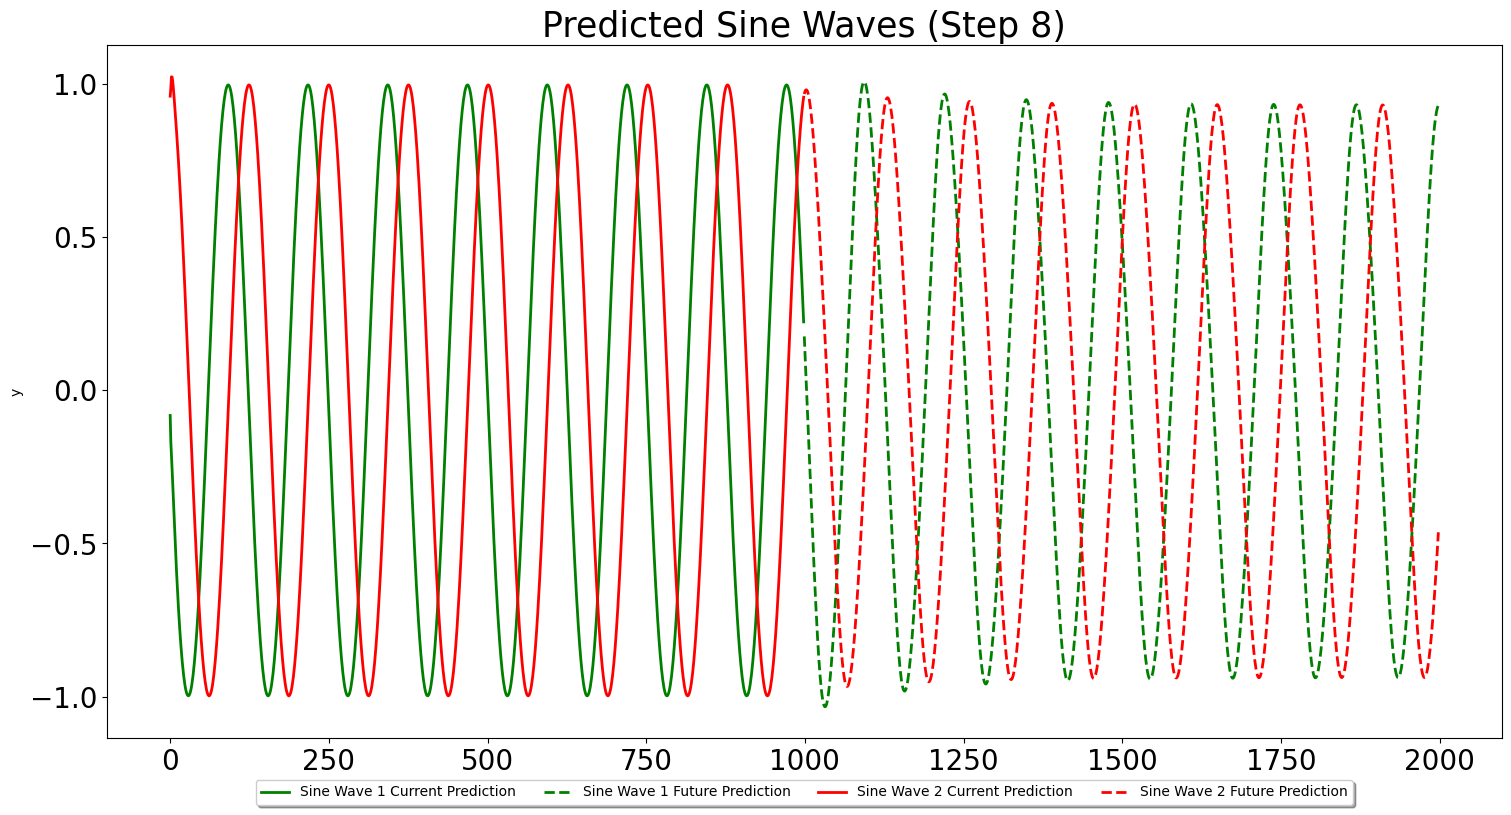

Step 9
Train Loss: 1.3804205991618801e-05
Train Loss: 1.3697585018235259e-05
Train Loss: 1.3437952475214843e-05
Train Loss: 1.3223042515164707e-05
Train Loss: 1.3116818081471138e-05
Train Loss: 1.2797633644368034e-05
Train Loss: 1.2671111107920296e-05
Train Loss: 1.2599251022038516e-05
Train Loss: 1.2561414223455358e-05
Train Loss: 1.2546734069474041e-05
Train Loss: 1.2524181329354178e-05
Train Loss: 1.249350043508457e-05
Train Loss: 1.245526709681144e-05
Train Loss: 1.2403700566210318e-05
Train Loss: 1.2324861017987132e-05
Train Loss: 1.2235457688802853e-05
Train Loss: 1.2169021829322446e-05
Train Loss: 1.2183025319245644e-05
Train Loss: 1.2039268767694011e-05
Train Loss: 1.198795871459879e-05
Test Loss: 1.0501455108169466e-05


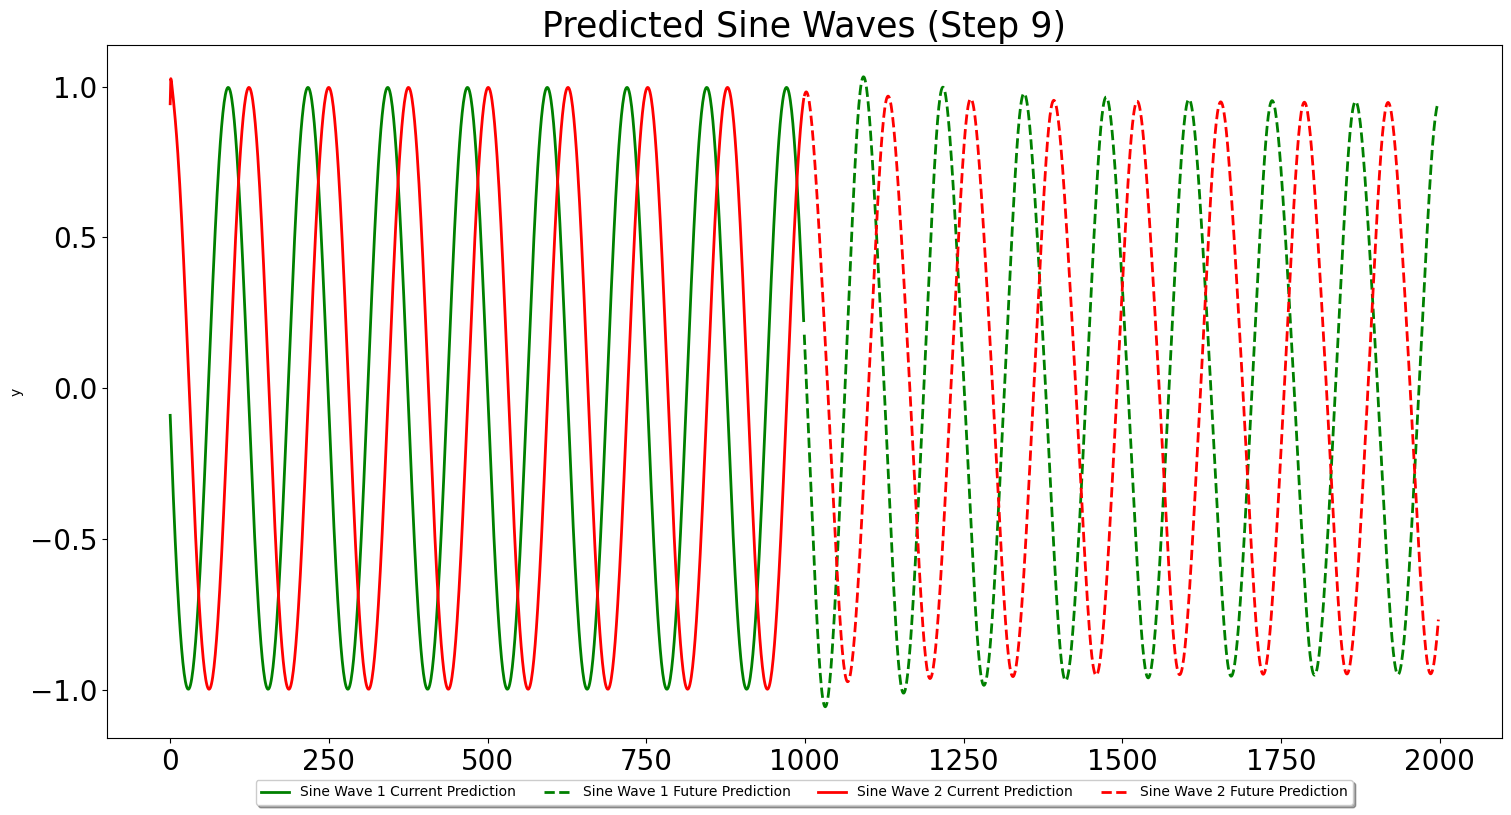

Step 10
Train Loss: 1.1917165466002189e-05
Train Loss: 1.1900810022780206e-05
Train Loss: 1.176077057607472e-05
Train Loss: 1.1699551578203682e-05
Train Loss: 1.8938084394903854e-05
Train Loss: 1.1436667591624428e-05
Train Loss: 1.1329594599374104e-05
Train Loss: 1.15468947115005e-05
Train Loss: 1.0742252925410867e-05
Train Loss: 1.0448272405483294e-05
Train Loss: 0.06487248092889786
Train Loss: 2.7554386178962886e-05
Train Loss: 0.00015298373182304204
Train Loss: 2.1099496734677814e-05
Train Loss: 1.509864887339063e-05
Train Loss: 1.1855750017275568e-05
Train Loss: 1.0645834663591813e-05
Train Loss: 9.436416803509928e-06
Train Loss: 8.77020283951424e-06
Train Loss: 8.630376214568969e-06
Test Loss: 1.037875972542679e-05


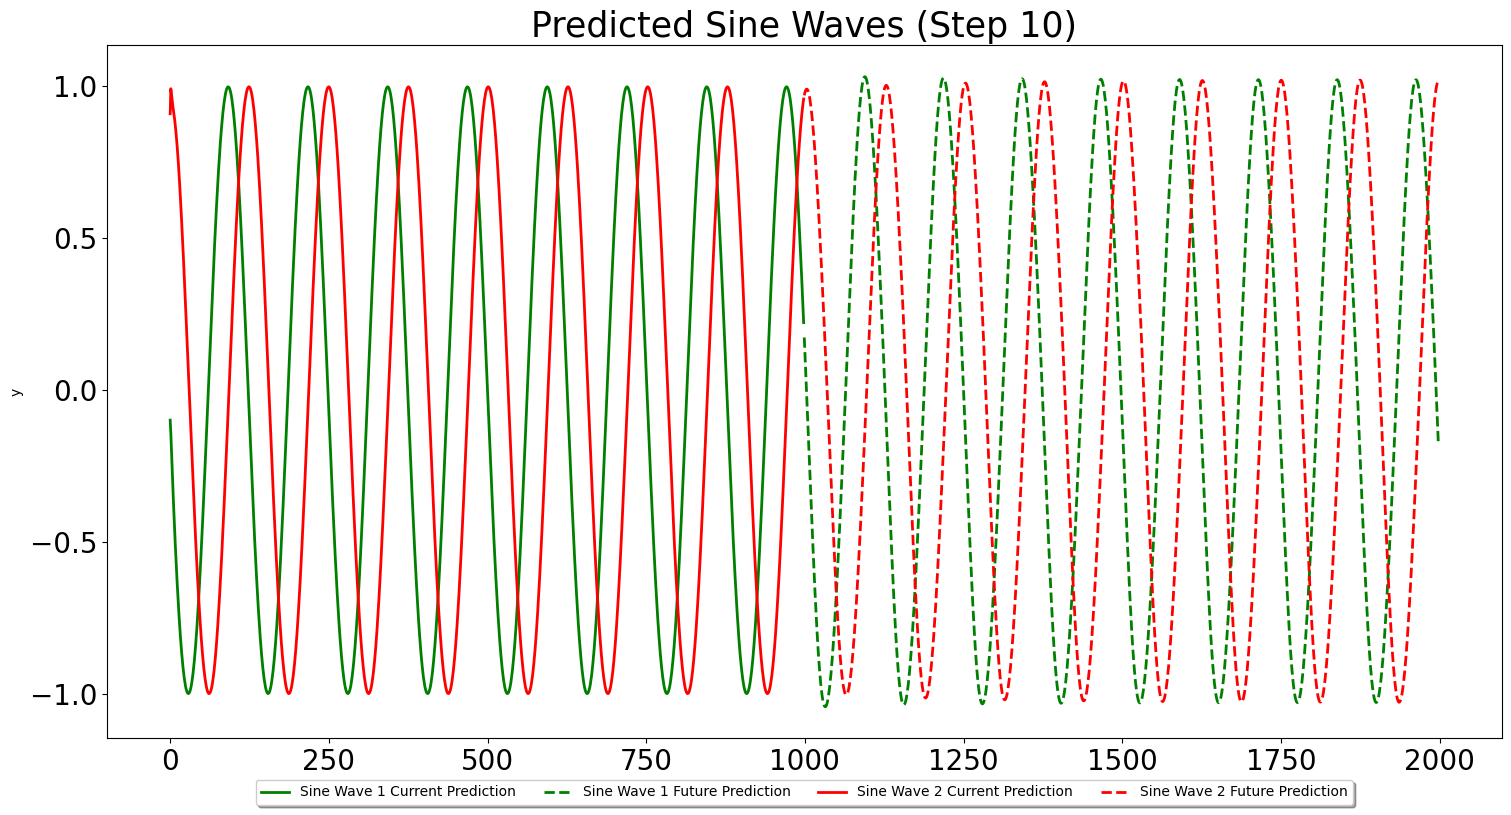

In [14]:
for i in range(n_steps):
    print(f'Step {i+1}')

    def closure(): # Required by LBFGS algorithm
        optimizer.zero_grad()
        outputs = lstm(train_input)
        loss = criterion(outputs, train_target)
        print("Train Loss:",loss.item())
        loss.backward()
        return loss
    
    optimizer.step(closure)

    # Predictions
    with torch.no_grad():
        future = 1000 # Next 1000 samples
        pred = lstm(test_input, future = future) # the n_test pred sine waves will be of length 999 + 1000 (Future)
        loss = criterion(pred[:,:-future], test_target) 
        # Hence here for all the n_test sine waves, we only take the first 999 values this way

        print("Test Loss:",loss.item())
        y = pred.detach().numpy()
        plt.figure(2, figsize=(18,9))
        plt.title(f"Predicted Sine Waves (Step {i+1})", fontsize = 25)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)

        n1 = test_input.shape[0] # n_test
        n2 = test_input.shape[1] # 999

        color = ['g', 'r']

        for num in range(n1):
            plt.plot(np.arange(n2), y[num,:n2], color[num], linewidth = 2.0, label = f'Sine Wave {num+1} Current Prediction')
            plt.plot(np.arange(n2, n2+future), y[num,n2:], color[num]+'--', linewidth = 2.0, label = f'Sine Wave {num+1} Future Prediction')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
        plt.show()

## Saving Model

In [15]:
torch.save(lstm, 'models/lstm_sine_wave_predictor.pt')

## Loading Model

In [16]:
model = torch.load('models/lstm_sine_wave_predictor.pt')

## Generate Wave

In [28]:
start = torch.tensor([[0.9]])
store = model.generate_sequence(start) # LSTM Model generator
store

tensor([[ 0.8316,  0.8286,  0.8116,  0.7825,  0.7466,  0.7061,  0.6625,  0.6166,
          0.5688,  0.5197,  0.4695,  0.4182,  0.3661,  0.3131,  0.2595,  0.2051,
          0.1501,  0.0946,  0.0385, -0.0180, -0.0748, -0.1318, -0.1890, -0.2462,
         -0.3032, -0.3599, -0.4161, -0.4716, -0.5261, -0.5795, -0.6315, -0.6818,
         -0.7303, -0.7767, -0.8207, -0.8622, -0.9009, -0.9367, -0.9694, -0.9990,
         -1.0253, -1.0482, -1.0678, -1.0840, -1.0968, -1.1062, -1.1123, -1.1152,
         -1.1148, -1.1114, -1.1049, -1.0954, -1.0831, -1.0681, -1.0503, -1.0300,
         -1.0072, -0.9820, -0.9546, -0.9249, -0.8930, -0.8592, -0.8235, -0.7859,
         -0.7465, -0.7056, -0.6630, -0.6191, -0.5737, -0.5272, -0.4795, -0.4307,
         -0.3810, -0.3305, -0.2792, -0.2273, -0.1749, -0.1220, -0.0688, -0.0154,
          0.0382,  0.0918,  0.1453,  0.1987,  0.2519,  0.3046,  0.3569,  0.4085,
          0.4594,  0.5095,  0.5585,  0.6063,  0.6528,  0.6978,  0.7411,  0.7826,
          0.8220,  0.8592,  

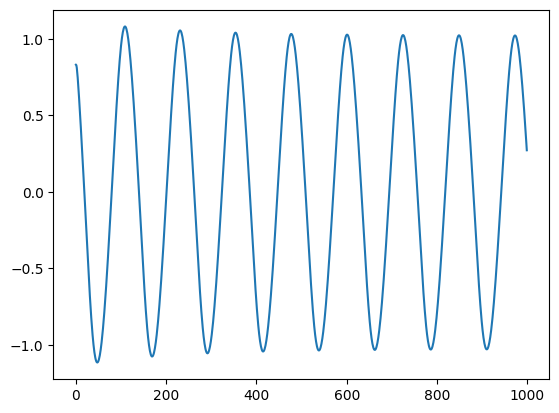

In [29]:
plt.plot(store[0])